In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
sns.set_theme()

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
# train_data=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
# test_data=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


2 null values are there in  recipe review.

In [5]:
train_data.dropna(how='any', inplace=True)
train_data.head(3)

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...


Adding Features to the datasets

In [6]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)

In [7]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'Day', 'Hour'],
      dtype='object')

## looking at time related features

In [8]:
train_data['Day'].unique()

array(['Thursday', 'Wednesday', 'Friday', 'Tuesday', 'Sunday', 'Monday',
       'Saturday'], dtype=object)

In [9]:
train_data['Day'].value_counts()

Thursday     12665
Wednesday      446
Monday         140
Tuesday        111
Friday          97
Saturday        94
Sunday          81
Name: Day, dtype: int64

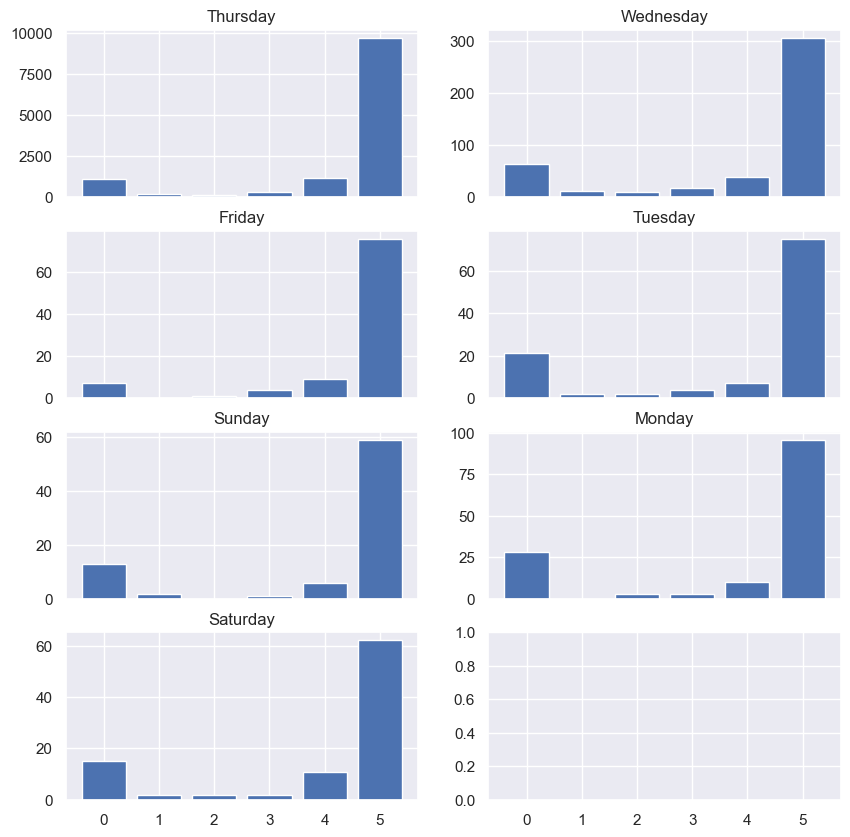

In [10]:
fig, axs=plt.subplots(4, 2, sharex=True)
fig.set_size_inches(10, 10)
for i, day in enumerate(train_data['Day'].unique()):
    data=train_data.loc[train_data['Day']==day]
    plot_data=data['Rating'].value_counts(ascending=True)
    axs[int(i/2), i%2].bar(plot_data.index, plot_data.values)
    axs[int(i/2), i%2].set_title(day)

Almost same distribution for all days

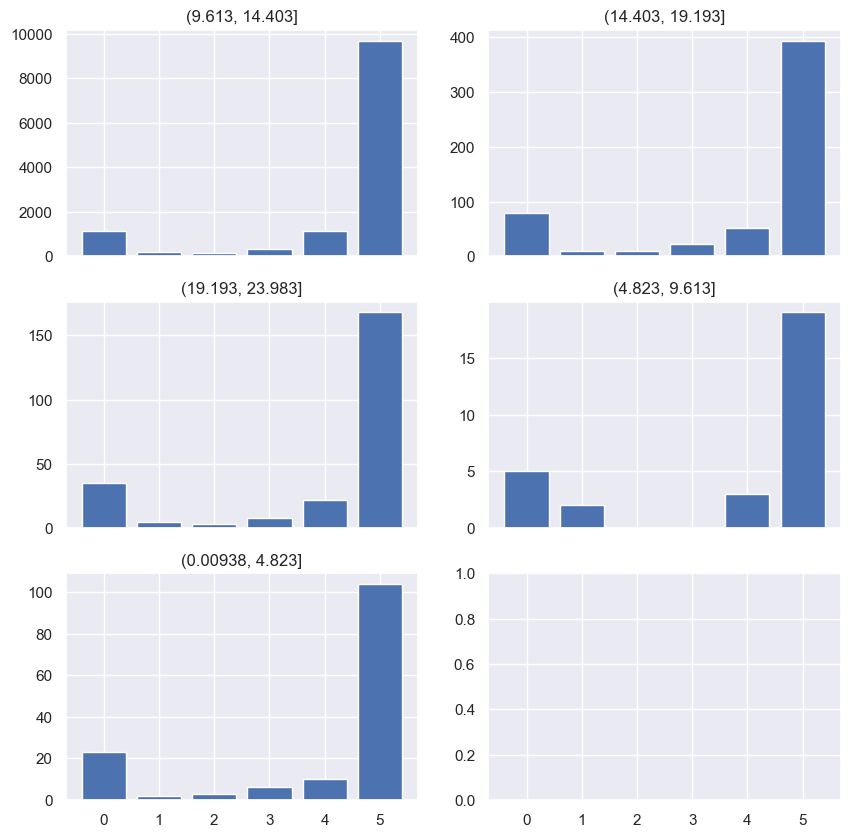

In [25]:
train_data['Hour_Category']=pd.cut(train_data['Hour'], 5)
fig, axs=plt.subplots(3, 2, sharex=True)
fig.set_size_inches(10, 10)
for i, hour in enumerate(train_data['Hour_Category'].unique()):
    data=train_data.loc[train_data['Hour_Category']==hour]
    plot_data=data['Rating'].value_counts(ascending=True)
    axs[int(i/2), i%2].bar(plot_data.index, plot_data.values)
    axs[int(i/2), i%2].set_title(hour)

## looking at numerical data

<Axes: xlabel='UserReputation', ylabel='Count'>

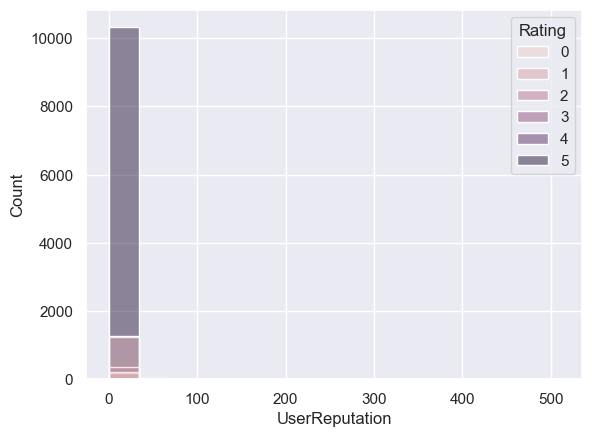

In [28]:
sns.histplot(train_data, x='UserReputation', hue='Rating')

<Axes: xlabel='BestScore', ylabel='Count'>

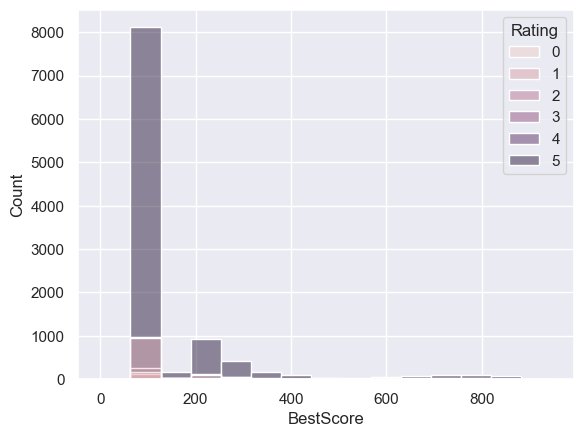

In [29]:
sns.histplot(train_data, x='BestScore', hue='Rating')

<Axes: xlabel='ReplyCount', ylabel='Count'>

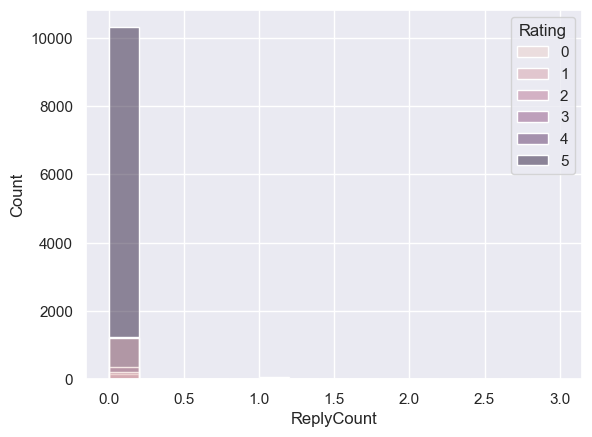

In [30]:
sns.histplot(train_data, x='ReplyCount', hue='Rating')

<Axes: xlabel='ThumbsUpCount', ylabel='Count'>

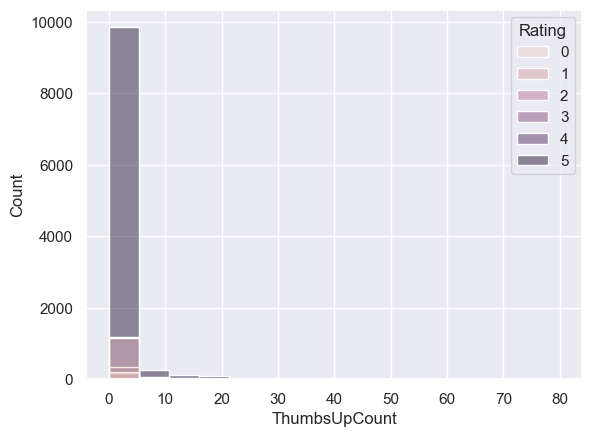

In [31]:
sns.histplot(train_data, x='ThumbsUpCount', hue='Rating')

<Axes: xlabel='ThumbsDownCount', ylabel='Count'>

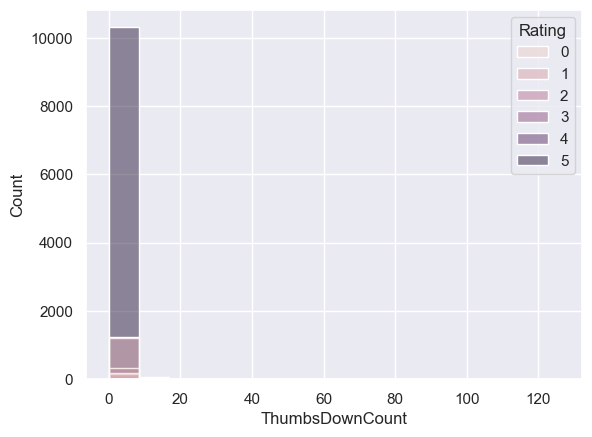

In [32]:
sns.histplot(train_data, x='ThumbsDownCount', hue='Rating')

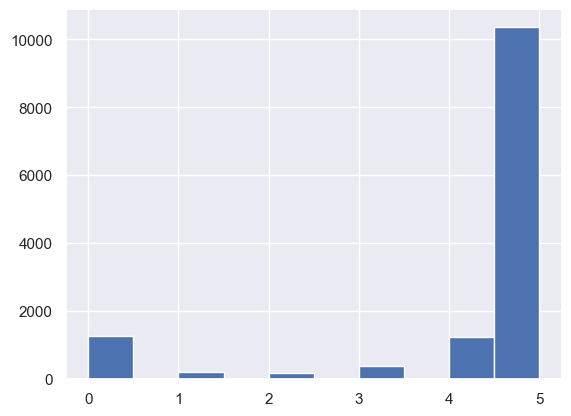

In [33]:
plt.hist(train_data['Rating']);

## Looking at Text Columns

In [51]:
vectorizer=CountVectorizer()
count_matrix=vectorizer.fit_transform(train_data['Recipe_Review'])

In [52]:
count_df=pd.DataFrame(count_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [54]:
count_df.sum().sort_values(ascending=False).to_excel('text_features.xlsx')

In [55]:
vectorizer2=CountVectorizer(stop_words='english')
count_matrix2=vectorizer2.fit_transform(train_data['Recipe_Review'])
count_df2=pd.DataFrame(count_matrix2.toarray(), columns=vectorizer2.get_feature_names_out())
count_df2.sum().sort_values(ascending=False).to_excel('text_features_trimmed.xlsx')

In [59]:
vectorizer3=TfidfVectorizer(stop_words='english')
count_matrix3=vectorizer3.fit_transform(train_data['Recipe_Review'])
count_df3=pd.DataFrame(count_matrix3.toarray(), columns=vectorizer3.get_feature_names_out())
count_df3.sum().sort_values(ascending=False).to_excel('text_features_tfidf.xlsx')

##  Checking Test Data

In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 4546 non-null   int64         
 1   RecipeNumber       4546 non-null   int64         
 2   RecipeCode         4546 non-null   int64         
 3   RecipeName         4546 non-null   object        
 4   CommentID          4546 non-null   object        
 5   UserID             4546 non-null   object        
 6   UserName           4546 non-null   object        
 7   UserReputation     4546 non-null   int64         
 8   CreationTimestamp  4546 non-null   int64         
 9   ReplyCount         4546 non-null   int64         
 10  ThumbsUpCount      4546 non-null   int64         
 11  ThumbsDownCount    4546 non-null   int64         
 12  BestScore          4546 non-null   int64         
 13  Recipe_Review      4546 non-null   object        
 14  Date    

No null values in any features